## Auto Encoder

In [1]:
# References
# Autoencoders.MNIST

In [2]:
#libs
import tensorflow
from tensorflow import keras
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import Conv2DTranspose
from tensorflow.keras.layers import LeakyReLU
from tensorflow.keras.layers import Activation
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Reshape
from tensorflow.keras.layers import Input
from tensorflow.keras.models import Model
from tensorflow.keras import backend as K
import numpy as np
from tensorflow.keras.layers import Dense, Input, Conv2D, LSTM, MaxPool2D, UpSampling2D
from sklearn.model_selection import train_test_split
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.utils import to_categorical
from numpy import argmax, array_equal
import matplotlib.pyplot as plt
import seaborn as sns
from tensorflow.keras.models import Model
from random import randint
import pandas as pd
import numpy as np
from tensorflow.keras import layers
from PIL import Image
from tensorflow.keras import regularizers
from tensorflow.keras import backend

### Task 1
#### Create an autoencoder model for encoding and decoding images and demonstrate

In [3]:
(x_train_valid, y_train_valid), (x_test, y_test) = keras.datasets.fashion_mnist.load_data()

In [4]:
x_train, x_validation, y_train, y_validation = train_test_split(x_train_valid, y_train_valid, test_size=0.2, random_state=0)

In [5]:
# Scale images to the [0, 1] range
x_train = x_train.astype("float32") / 255
x_validation = x_validation.astype("float32") / 255
x_test = x_test.astype("float32") / 255
x_train.shape, x_validation.shape, x_test.shape

((48000, 28, 28), (12000, 28, 28), (10000, 28, 28))

In [6]:
x_train = x_train.reshape(-1, 784)
x_validation = x_validation.reshape(-1, 784)
x_test = x_test.reshape(-1, 784)

x_train.shape, x_validation.shape, x_test.shape

((48000, 784), (12000, 784), (10000, 784))

In [7]:
input_layer = Input(shape=(784,))   # 28*28
encoded = layers.Dense(128, activation='relu')(input_layer)
encoded = layers.Dense(64, activation='relu')(encoded)
encoded = layers.Dense(32, activation='relu')(encoded)

decoded = layers.Dense(64, activation='relu')(encoded)
decoded = layers.Dense(128, activation='relu')(decoded)
decoded = layers.Dense(784, activation='sigmoid')(decoded)

# reconstruction model:
autoencoder = keras.Model(input_layer, decoded)

# encoder model:
encoder = keras.Model(input_layer, encoded)

# decoder model:
encoded_input = keras.Input(shape=(32,))
decoder_layer = autoencoder.layers[-3]  # decoder layers of autoencoder model
decoder = keras.Model(encoded_input, decoder_layer(encoded_input))
autoencoder.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 784)]             0         
_________________________________________________________________
dense (Dense)                (None, 128)               100480    
_________________________________________________________________
dense_1 (Dense)              (None, 64)                8256      
_________________________________________________________________
dense_2 (Dense)              (None, 32)                2080      
_________________________________________________________________
dense_3 (Dense)              (None, 64)                2112      
_________________________________________________________________
dense_4 (Dense)              (None, 128)               8320      
_________________________________________________________________
dense_5 (Dense)              (None, 784)               101136

In [8]:
autoencoder.compile(optimizer='adam', loss='mse')
# early_stopping = EarlyStopping(monitor='val_loss', min_delta=0, patience=10, verbose=1, mode='auto')
# model.fit(x_train, x_train, epochs=30, batch_size=2048, validation_data=(x_validation, x_validation), callbacks=[early_stopping])
from tensorflow.keras.callbacks import TensorBoard
import tensorflow as tf
import keras

tboard_callback = tf.keras.callbacks.TensorBoard(log_dir = "/tmp/autoencoder",
                                                 histogram_freq = 1,
                                                 profile_batch = '500,520')

autoencoder.fit(x_train, x_train,
                epochs=30,
                batch_size=2048,
                shuffle=True,
                validation_data=(x_validation, x_validation),
                callbacks = [tboard_callback])

Epoch 1/30
24/24 [==============================] - 1s 43ms/step - loss: 0.1452 - val_loss: 0.0872
Epoch 2/30
24/24 [==============================] - 1s 21ms/step - loss: 0.0776 - val_loss: 0.0564
Epoch 3/30
24/24 [==============================] - 0s 21ms/step - loss: 0.0527 - val_loss: 0.0449
Epoch 4/30
24/24 [==============================] - 0s 21ms/step - loss: 0.0430 - val_loss: 0.0375
Epoch 5/30
24/24 [==============================] - 1s 21ms/step - loss: 0.0357 - val_loss: 0.0313
Epoch 6/30
24/24 [==============================] - 0s 21ms/step - loss: 0.0309 - val_loss: 0.0283
Epoch 7/30
24/24 [==============================] - 0s 21ms/step - loss: 0.0276 - val_loss: 0.0265
Epoch 8/30
24/24 [==============================] - 1s 21ms/step - loss: 0.0260 - val_loss: 0.0253
Epoch 9/30
24/24 [==============================] - 0s 21ms/step - loss: 0.0249 - val_loss: 0.0242
Epoch 10/30
24/24 [==============================] - 0s 20ms/step - loss: 0.0240 - val_loss: 0.0238
Epoch 11/

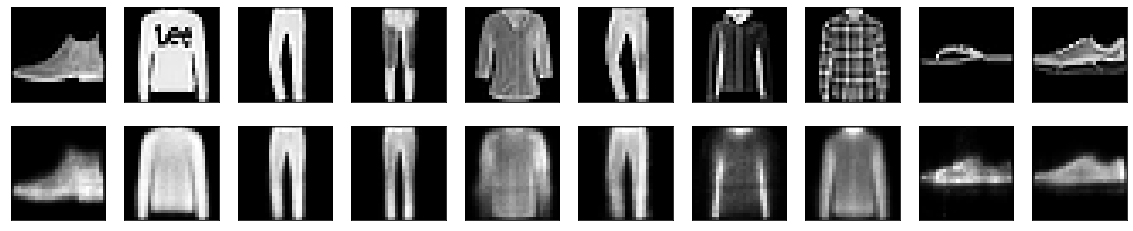

In [9]:
predictions = autoencoder.predict(x_test)
n = 10
plt.figure(figsize=(20, 4))
for i in range(n):
    # original
    ax = plt.subplot(2, n, i + 1)
    plt.imshow(x_test[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # reconstruction
    ax = plt.subplot(2, n, i + 1 + n)
    plt.imshow(predictions[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

In [10]:

[TensorBoard(log_dir='/tmp/autoencoder', histogram_freq=0, write_graph=True)]

In [11]:
%load_ext tensorboard
%tensorboard --logdir=/tmp/autoencoder
# %reload_ext tensorboard


Reusing TensorBoard on port 6006 (pid 28519), started 2:02:16 ago. (Use '!kill 28519' to kill it.)

### Task 2
#### Use an autoencoder model to denoise noisy images

In [12]:
x_train = x_train.reshape(-1, 28, 28, 1)
x_validation = x_validation.reshape(-1, 28, 28, 1)
x_test = x_test.reshape(-1, 28, 28, 1)

x_train.shape, x_validation.shape, x_test.shape

((48000, 28, 28, 1), (12000, 28, 28, 1), (10000, 28, 28, 1))

In [13]:
input_layer = Input(shape=(28, 28, 1))

x = layers.Conv2D(16, (3, 3), activation='relu', padding='same')(input_layer)
x = layers.MaxPooling2D((2, 2), padding='same')(x)
x = layers.Conv2D(8, (3, 3), activation='relu', padding='same')(x)
x = layers.MaxPooling2D((2, 2), padding='same')(x)
x = layers.Conv2D(8, (3, 3), activation='relu', padding='same')(x)
encoded = layers.MaxPooling2D((2, 2), padding='same')(x)

x = layers.Conv2D(8, (3, 3), activation='relu', padding='same')(encoded)
x = layers.UpSampling2D((2, 2))(x)
x = layers.Conv2D(8, (3, 3), activation='relu', padding='same')(x)
x = layers.UpSampling2D((2, 2))(x)
x = layers.Conv2D(16, (3, 3), activation='relu')(x)
x = layers.UpSampling2D((2, 2))(x)
decoded = layers.Conv2D(1, (3, 3), activation='sigmoid', padding='same')(x)

autoencoder = keras.Model(input_layer, decoded)
autoencoder.compile(optimizer='adam', loss='binary_crossentropy')

In [14]:
autoencoder.fit(x_train, x_train,
                epochs=30,
                batch_size=2048,
                shuffle=True,
                validation_data=(x_validation, x_validation))

Epoch 1/30
24/24 [==============================] - 18s 717ms/step - loss: 0.6681 - val_loss: 0.5966
Epoch 2/30
24/24 [==============================] - 18s 730ms/step - loss: 0.5615 - val_loss: 0.4577
Epoch 3/30
24/24 [==============================] - 17s 722ms/step - loss: 0.4306 - val_loss: 0.3663
Epoch 4/30
24/24 [==============================] - 18s 768ms/step - loss: 0.3582 - val_loss: 0.3435
Epoch 5/30
24/24 [==============================] - 18s 764ms/step - loss: 0.3406 - val_loss: 0.3326
Epoch 6/30
24/24 [==============================] - 18s 742ms/step - loss: 0.3319 - val_loss: 0.3265
Epoch 7/30
24/24 [==============================] - 18s 765ms/step - loss: 0.3259 - val_loss: 0.3223
Epoch 8/30
24/24 [==============================] - 19s 788ms/step - loss: 0.3217 - val_loss: 0.3192
Epoch 9/30
24/24 [==============================] - 19s 792ms/step - loss: 0.3187 - val_loss: 0.3169
Epoch 10/30
24/24 [==============================] - 19s 791ms/step - loss: 0.3160 - val_lo

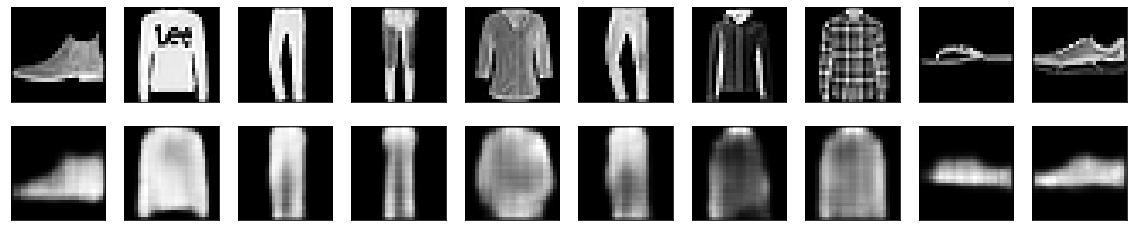

In [15]:
predictions = autoencoder.predict(x_test)

n = 10
plt.figure(figsize=(20, 4))
for i in range(n):
    # original
    ax = plt.subplot(2, n, i + 1)
    plt.imshow(x_test[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # reconstruction
    ax = plt.subplot(2, n, i + 1 + n)
    plt.imshow(predictions[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

In [16]:
noise_factor = 0.5
x_train_noisy = x_train + noise_factor * np.random.normal(loc=0.0, scale=1.0, size=x_train.shape) 
x_validation_noisy = x_validation + noise_factor * np.random.normal(loc=0.0, scale=1.0, size=x_validation.shape) 
x_test_noisy = x_test + noise_factor * np.random.normal(loc=0.0, scale=1.0, size=x_test.shape) 

x_train_noisy = np.clip(x_train_noisy, 0., 1.)
x_validation_noisy = np.clip(x_validation_noisy, 0., 1.)
x_test_noisy = np.clip(x_test_noisy, 0., 1.)

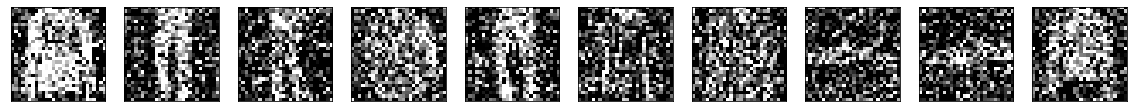

In [17]:
n = 10
plt.figure(figsize=(20, 2))
for i in range(1, n + 1):
    ax = plt.subplot(1, n, i)
    plt.imshow(x_test_noisy[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

In [18]:
input_layer = keras.Input(shape=(28, 28, 1))

x = layers.Conv2D(32, (3, 3), activation='relu', padding='same')(input_layer)
x = layers.MaxPooling2D((2, 2), padding='same')(x)
x = layers.Conv2D(32, (3, 3), activation='relu', padding='same')(x)
encoded = layers.MaxPooling2D((2, 2), padding='same')(x)

# At this point the representation is (7, 7, 32)

x = layers.Conv2D(32, (3, 3), activation='relu', padding='same')(encoded)
x = layers.UpSampling2D((2, 2))(x)
x = layers.Conv2D(32, (3, 3), activation='relu', padding='same')(x)
x = layers.UpSampling2D((2, 2))(x)
decoded = layers.Conv2D(1, (3, 3), activation='sigmoid', padding='same')(x)

autoencoder = keras.Model(input_layer, decoded)
autoencoder.compile(optimizer='adam', loss='binary_crossentropy')
autoencoder.summary()

Model: "model_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         [(None, 28, 28, 1)]       0         
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 28, 28, 32)        320       
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 14, 14, 32)        0         
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 14, 14, 32)        9248      
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 7, 7, 32)          0         
_________________________________________________________________
conv2d_9 (Conv2D)            (None, 7, 7, 32)          9248      
_________________________________________________________________
up_sampling2d_3 (UpSampling2 (None, 14, 14, 32)        0   

In [19]:
autoencoder.fit(x_train_noisy, x_train,
                epochs=30,
                batch_size=2048,
                shuffle=True,
                validation_data=(x_validation_noisy, x_validation))

# autoencoder.fit(x_train_noisy, x_train,
#                 epochs=30,
#                 batch_size=2048,
#                 shuffle=True,
#                 validation_data=(x_validation_noisy, x_validation),
#                 callbacks = [tboard_callback])

Epoch 1/30
24/24 [==============================] - 36s 1s/step - loss: 0.6337 - val_loss: 0.4097
Epoch 2/30
24/24 [==============================] - 35s 1s/step - loss: 0.3864 - val_loss: 0.3518
Epoch 3/30
24/24 [==============================] - 36s 1s/step - loss: 0.3459 - val_loss: 0.3332
Epoch 4/30
24/24 [==============================] - 36s 1s/step - loss: 0.3313 - val_loss: 0.3262
Epoch 5/30
24/24 [==============================] - 36s 1s/step - loss: 0.3260 - val_loss: 0.3225
Epoch 6/30
24/24 [==============================] - 36s 1s/step - loss: 0.3229 - val_loss: 0.3199
Epoch 7/30
24/24 [==============================] - 36s 1s/step - loss: 0.3201 - val_loss: 0.3179
Epoch 8/30
24/24 [==============================] - 36s 1s/step - loss: 0.3182 - val_loss: 0.3164
Epoch 9/30
24/24 [==============================] - 35s 1s/step - loss: 0.3159 - val_loss: 0.3146
Epoch 10/30
24/24 [==============================] - 35s 1s/step - loss: 0.3140 - val_loss: 0.3134
Epoch 11/30
24/24 [

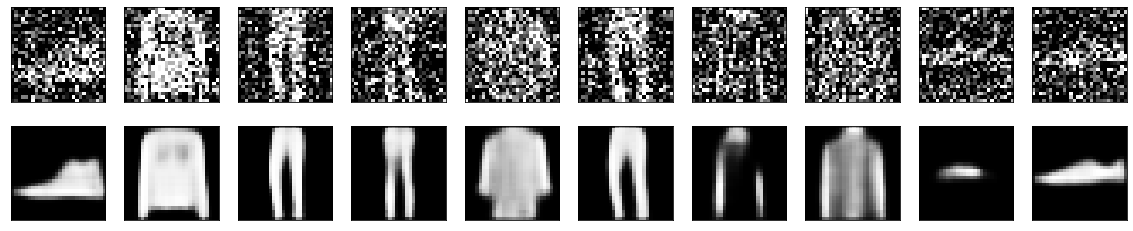

In [20]:
predictions = autoencoder.predict(x_test)

n = 10
plt.figure(figsize=(20, 4))
for i in range(n):
    # noisy
    ax = plt.subplot(2, n, i + 1)
    plt.imshow(x_test_noisy[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # reconstruction
    ax = plt.subplot(2, n, i + 1 + n)
    plt.imshow(predictions[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()